In [1]:
from matplotlib import pyplot as plt
import numpy as np
import numba

In [2]:
%matplotlib widget

In [3]:
from dataclasses import dataclass
from typing import Callable

In [84]:
@numba.jit(nopython=True)
def bb_int_map(f: Callable[(complex,), int], width: int, height: int, center: complex, scale: complex, *args):
    result = np.zeros((height, width), np.int64)
    for j in range(height):
        for i in range(width):
            z = center + (i - width // 2 + (j - height // 2) * 1j) * scale
            result[j, i] = f(z, *args)
    return result


@dataclass
class BoundingBox:
    width: int
    height: int
    center: complex
    extent: complex
    
    def scale(self) -> float:
        """Computes the correct scale to display the selected region.
        
        Returns:
            floating point value that scales pixels to desired complex domain.
        """
        return max(self.extent.real / self.width,
                   self.extent.imag / self.height)
    
    def zeros(self, dtype=int):
        """Create a 2D array with the specified shape of (width, height)."""
        return np.zeros(dtype=dtype, shape=(self.width, self.height))
    
    def int_map(self, f, *args):
        """Map a function over the given complex domain."""
        return bb_int_map(f, self.width, self.height, self.center, self.scale(), *args)
    
    def plot(self, value, name="z", ax=None):
        if ax is None:
            fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        else:
            fig = None
        plot_extent = (self.width + 1j * self.height) * self.scale()
        z1 = self.center - plot_extent / 2
        z2 = z1 + plot_extent
        ax.imshow(value, origin='lower', extent=(z1.real, z2.real, z1.imag, z2.imag))
        ax.set_xlabel(f"$\Re({name})$")
        ax.set_ylabel(f"$\Im({name})$")
        return fig, ax

In [71]:
@numba.jit(nopython=True)
def iteration_count(f: Callable[(complex,), complex], stop: Callable[(complex,), bool], start: complex, max_iter: int, *args) -> int:
    x = start
    for k in range(max_iter):
        x = f(x, *args)
        if stop(x):
            break
    return k

In [72]:
@numba.jit(nopython=True)
def radius_2_condition(z: complex) -> bool:
    return (z*z.conjugate()).real >= 4.0

In [73]:
def mandelbrot_ic(max_iter: int) -> Callable[(complex,), int]:
    @numba.jit(nopython=True)
    def f(c: complex):
        return iteration_count(lambda z, c: z**2 + c, radius_2_condition, 0.0, max_iter, c)
    return f

In [74]:
def julia_ic(max_iter: int) -> Callable[(complex, complex), int]:
    @numba.jit(nopython=True)
    def f(z0: complex, c: complex):
        return iteration_count(lambda z, c: z**2 + c, radius_2_condition, z0, max_iter, c)
    return f    

In [75]:
bb = BoundingBox(512, 512, -0.8+0.0j, 3.0+2.0j)

In [76]:
mb = mandelbrot_ic(256)
julia = julia_ic(256)

In [77]:
%%time
mandelbrot_im = bb.int_map(mb)

CPU times: user 795 ms, sys: 0 ns, total: 795 ms
Wall time: 639 ms


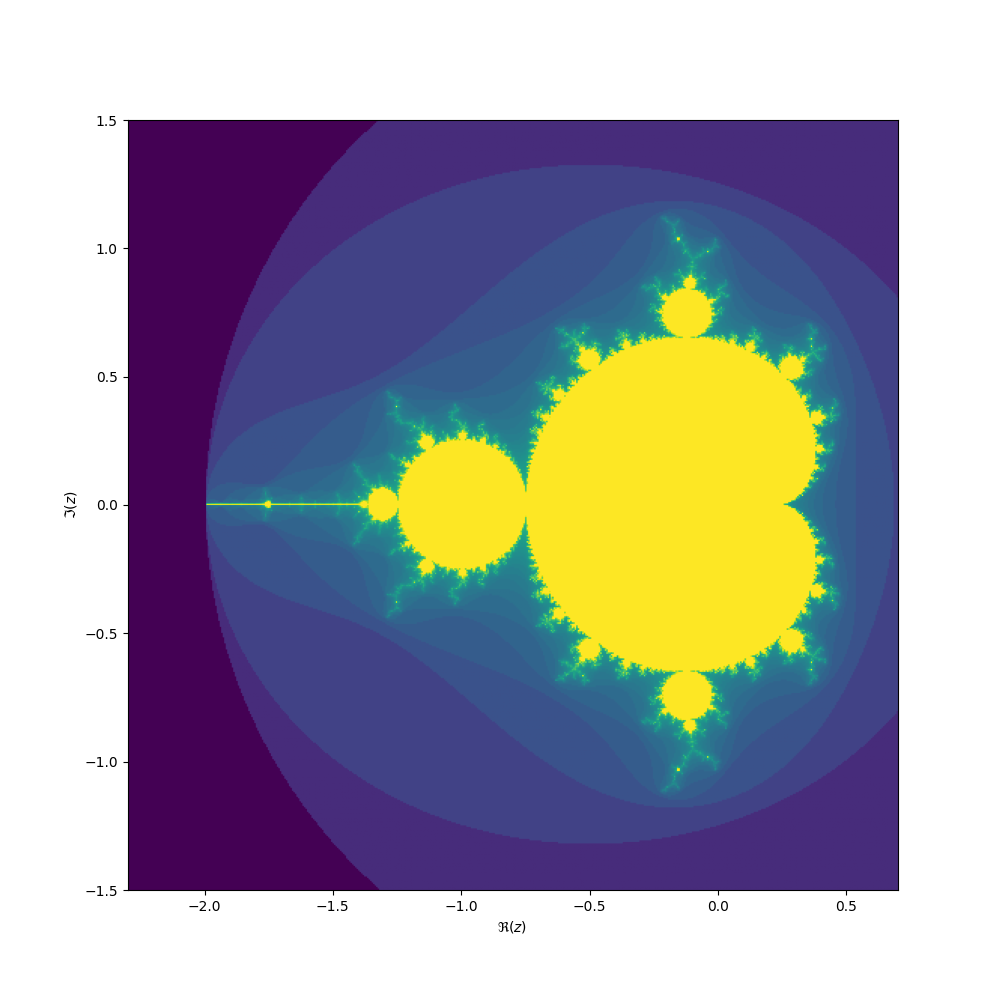

In [78]:
fig, ax = bb.plot(np.log(mandelbrot_im+1))

In [79]:
fig.savefig("../fig/mandelbrot-all.png", dpi=100, bbox_inches='tight')

In [80]:
c = -1.1195+0.2718j
bb2 = BoundingBox(
    width = 1024,
    height = 1024,
    center = c,
    extent = 0.005+0.005j)

In [83]:
%%time
im = bb2.int_map(mandelbrot_ic(1024))

CPU times: user 981 ms, sys: 0 ns, total: 981 ms
Wall time: 828 ms


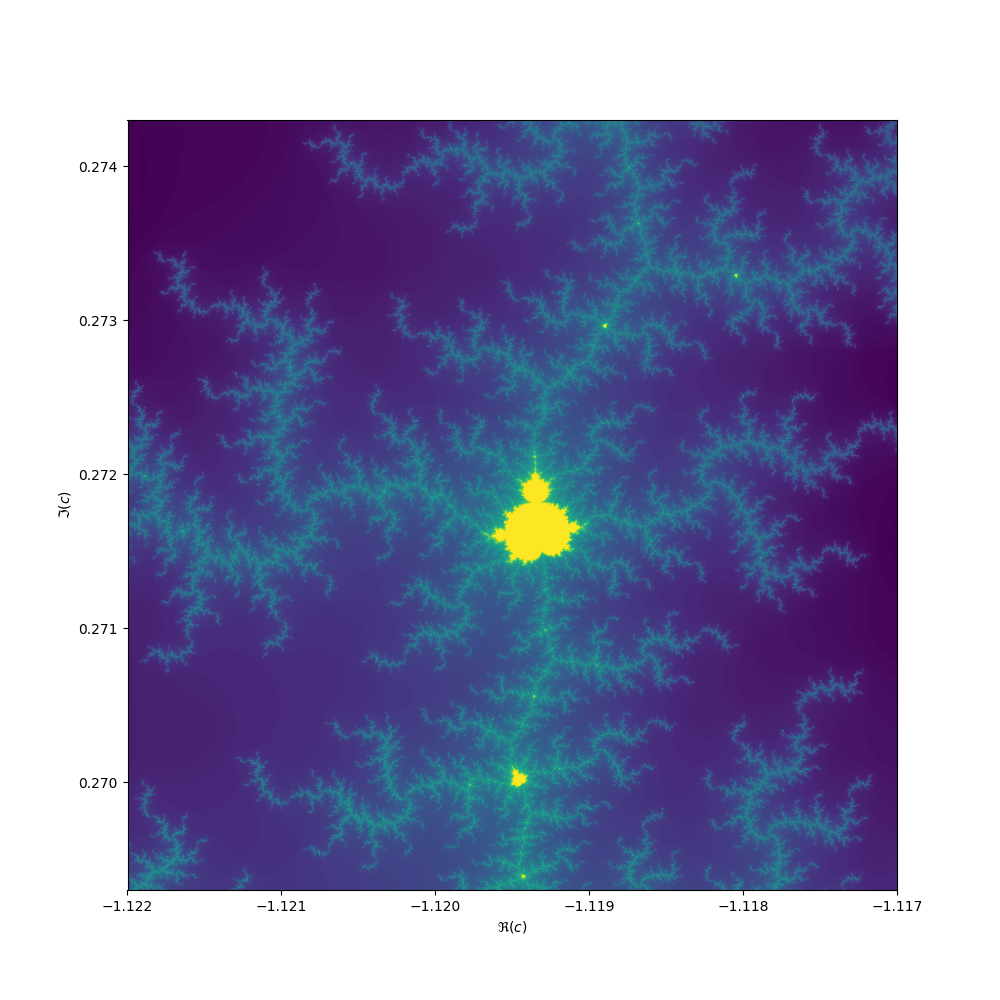

In [16]:
fig, ax = bb2.plot(np.log(im), name="c")

In [19]:
fig.savefig("../fig/mandelbrot-1.png", dpi=100, bbox_inches='tight')

In [20]:
bb3 = BoundingBox(1024, 512, 0.0+0.0j, 4.0+2.1j)

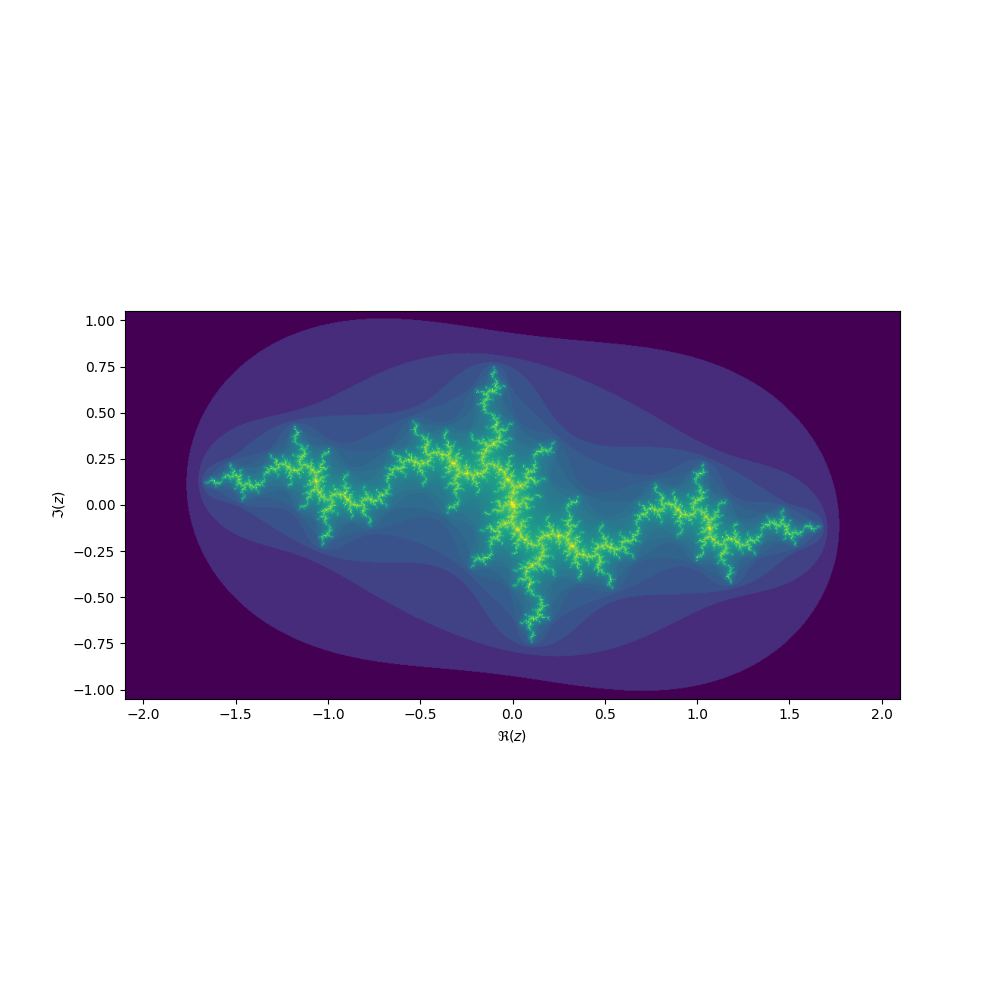

In [21]:
fig, ax = bb3.plot(np.log(bb3.int_map(julia_ic(256), c) + 1))

In [22]:
fig.savefig("../fig/julia-1.png", dpi=100, bbox_inches='tight')

In [23]:
import ipywidgets as widgets

interactive(children=(FloatSlider(value=-0.5, description='x', max=1.0, min=-2.0, step=0.01), FloatSlider(valu…

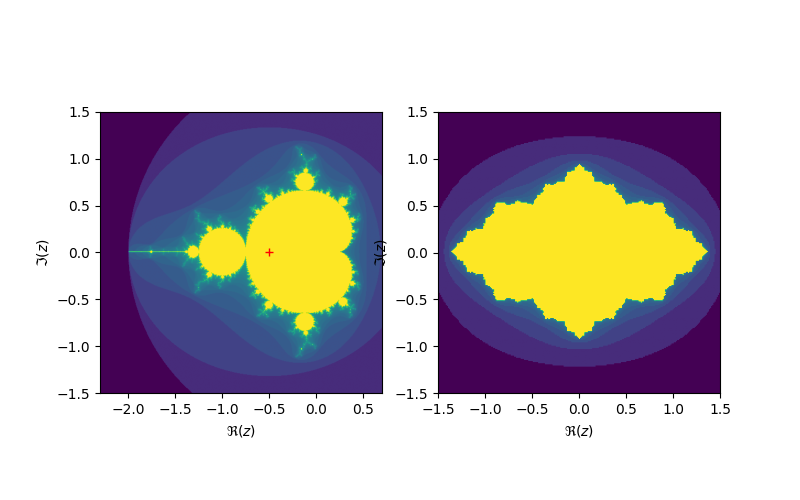

In [29]:
y = widgets.FloatSlider(value=0.0, min=-1.5, max=1.5, step=0.01, orientation='vertical')
x = widgets.FloatSlider(value=0.0, min=-2.0, max=1.0, step=0.01, orientation='horizontal')
layout = widgets.Layout(grid_template_columns='0.1fr 1fr')

mbfig, ax = plt.subplots(1, 2, figsize=(8, 5))
bb.plot(np.log(mandelbrot_im+1), ax=ax[0])
mbloc = ax[0].plot(0, 0, 'r+')

def update_mandel_plot(x, y):
    mbloc[0].set_xdata(x)
    mbloc[0].set_ydata(y)
    mbfig.canvas.draw()

julia_it = julia_ic(256)
bbj = BoundingBox(256, 256, 0.0+0.0j, 3+3j)
juim = bbj.plot(np.log(bbj.int_map(julia_it, 0) + 1), ax=ax[1])

def update_julia_plot(x, y):
    bbj.plot(np.log(bbj.int_map(julia_it, x+1j*y) + 1), ax=ax[1])
    
@widgets.interact(x=(-2, 1.0, 0.01), y=(-1.5, 1.5, 0.01))
def update(x, y):
    update_mandel_plot(x, y)
    update_julia_plot(x, y)